![Elbit AI Academy](images/ai_acadamy.jpg)

# <center> Project - deep learning modeling and optimization </center>

## [Objective](./project-instructions.ipynb)

http://datahacker.rs/vgg16-vgg19-network-implemented-tensorflow-2-0/

https://www.tensorflow.org/datasets/catalog/imagenet_v2

In [1]:
import cv2
import requests
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.python.keras.utils.np_utils import to_categorical

In [2]:
import multiprocessing
import time

#### Definitions

In [3]:
isRunningOnLocalMachine  = 0
isRunningOnRemoteMachine = 1

#### Environment

In [4]:
images_dir = 'images';

In [5]:
!mkdir images_dir    # for images

mkdir: cannot create directory ‘images_dir’: File exists


In [6]:
!mkdir "optimized_FP32" 

mkdir: cannot create directory ‘optimized_FP32’: File exists


In [7]:
!mkdir "optimized_FP16" 

mkdir: cannot create directory ‘optimized_FP16’: File exists


In [8]:
!mkdir "optimized_INT8" 

mkdir: cannot create directory ‘optimized_INT8’: File exists


#### limit GPU memory 

In [9]:
gpu_memory = 3*1024*1024
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=gpu_memory)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)  

'\ngpu_memory = 3*1024*1024\ngpus = tf.config.list_physical_devices(\'GPU\')\nif gpus:\n  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU\n  try:\n    tf.config.experimental.set_virtual_device_configuration(\n        gpus[0],\n        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=gpu_memory)])\n    logical_gpus = tf.config.experimental.list_logical_devices(\'GPU\')\n    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")\n  except RuntimeError as e:\n    # Virtual devices must be set before GPUs have been initialized\n    print(e)\n'

#### Create Model:

In [10]:
# VGG 19 Model
class VGG19(Sequential):
    def __init__(self, input_shape):
        super().__init__()

        self.add(Conv2D(64, kernel_size=(3,3), padding= 'same',
                        activation= 'relu', input_shape= input_shape))
        self.add(Conv2D(64, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(128, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(128, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.5))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.5))
        self.add(Dense(1000, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.003),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [11]:
model = VGG19((224, 224, 3))

#### Weights can be found 
https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5

In [12]:
url = "https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5"
r = requests.get(url, allow_redirects=True)
open('weight/vgg19_weights_tf_dim_ordering_tf_kernels.h5', 'wb').write(r.content)

574710816

In [13]:
# Loads the weights
model.load_weights("weight/vgg19_weights_tf_dim_ordering_tf_kernels.h5")

In [14]:
# load classes
from imagenet_classes import classes

In [15]:
#print(classes)

In [16]:
def download(images):
    for i in range(len(images)):
        r = requests.get(images[i], allow_redirects=True)
        open('tests/test_image_'+ str(i) +'.jpg', 'wb').write(r.content)

def test(image_path):
    test_image = cv2.imread(image_path)
    test_image = cv2.resize(test_image, (224, 224))

    plt.figure()
    plt.imshow(test_image)

    # Simply put, numpy.newaxis is used to increase the dimension of the existing array by one more dimension, 
    # when used once. Thus, 3D array becomes 4D array
    # see: https://i.stack.imgur.com/zkMBy.png
    test_image = test_image[np.newaxis, :]
    
    test_image = tf.cast(test_image, tf.float32)
    
    print(type(test_image))
    
    predicted_value = model.predict_classes(test_image)
    print(predicted_value)
    plt.axis('off')
    plt.title(classes[predicted_value[0]])
    
def getImage(image_path):
    test_image = cv2.imread(image_path)
    test_image = cv2.resize(test_image, (224, 224))
    
    test_image = test_image[np.newaxis, :]
    test_image = tf.cast(test_image, tf.float32)
        
    return test_image                           
    

In [17]:
images = ["https://images.unsplash.com/photo-1546768292-fb12f6c92568?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=750&q=80",
          "https://images.unsplash.com/photo-1555041469-a586c61ea9bc?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=750&q=80"]

In [18]:
download(images)

<class 'tensorflow.python.framework.ops.EagerTensor'>


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[817]


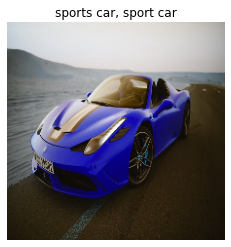

In [19]:
test("tests/test_image_0.jpg")

<class 'tensorflow.python.framework.ops.EagerTensor'>
[831]


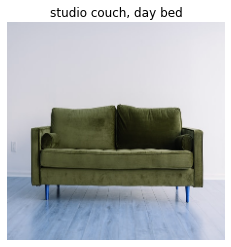

In [20]:
test("tests/test_image_1.jpg")

<class 'tensorflow.python.framework.ops.EagerTensor'>
[0]


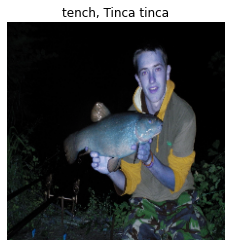

In [21]:
test("tests/test_image_2.jpg")

<class 'tensorflow.python.framework.ops.EagerTensor'>
[1]


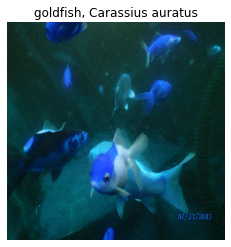

In [22]:
test("tests/test_image_3.jpeg")

<class 'tensorflow.python.framework.ops.EagerTensor'>
[996]


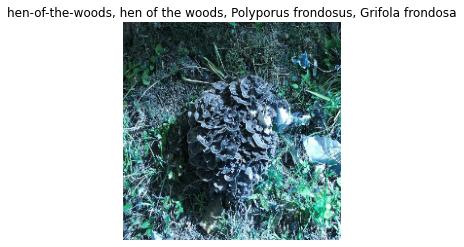

In [23]:
test("tests/test_image_4.jpeg")

In [24]:
mI = getImage("tests/test_image_0.jpg")
type(mI.shape)

tensorflow.python.framework.tensor_shape.TensorShape

In [25]:
predicted_value = model.predict_classes(mI)
predicted_value

array([817])

### Load dataset

In [26]:
import tensorflow.keras as keras
import tensorflow as tf
import tensorflow_datasets as tfds

DATASET_NAME = 'imagenet_v2'

if (isRunningOnLocalMachine == 1):

    print("Running on local machine...")
    dataset_test_raw, dataset_info = tfds.load(
        name=DATASET_NAME,
        data_dir=images_dir,
        with_info=True,
        as_supervised=True,
        shuffle_files=True,
        download=False,        # should be True, to force download
        split='test'
    )

else:

    print("Running on remote machine...")
    dataset_test_raw, dataset_info = tfds.load(
            name=DATASET_NAME,
            data_dir=images_dir,
            with_info=True,
            as_supervised=True,
            shuffle_files=True,
            download=True,        # should be True, to force download
            split='test'
        )
    
    

Running on remote machine...


In [27]:
print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')

Raw test dataset: <_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
Raw test dataset size: 10000 



In [28]:
import tensorflow as tf
import tensorflow_datasets as tfds

if (isRunningOnLocalMachine == 1):
    ds = tfds.load('imagenet_v2', split='test', shuffle_files=True, download=False)
    type(ds)
else:
    ds = tfds.load('imagenet_v2', split='test', shuffle_files=True, download=True)
    type(ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling imagenet_v2-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset imagenet_v2 downloaded and prepared to /root/tensorflow_datasets/imagenet_v2/matched-frequency/3.0.0. Subsequent calls will reuse this data.


tensorflow.python.data.ops.dataset_ops._OptionsDataset

In [ ]:
from tensorflow.python.keras.utils.np_utils import to_categorical
import numpy as np

list_images = []
list_labels = []
for example in ds:
    image = example["image"]
    image = tf.image.resize(image, [224,224])
    list_images.append(image)
    label = example["label"]
    label = to_categorical(label, num_classes=1000)
    list_labels.append(label)
    
x_test = np.array(list_images) 
y_test = np.array(list_labels, dtype=np.ndarray)
(x_test.shape, y_test.shape)

## Explore dataset

In [49]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='imagenet_v2',
    full_name='imagenet_v2/matched-frequency/3.0.0',
    description="""
    ImageNet-v2 is an ImageNet test set (10 per class) collected by closely
    following the original labelling protocol. Each image has been labelled by
    at least 10 MTurk workers, possibly more, and depending on the strategy used to
    select which images to include among the 10 chosen for the given class there are
    three different versions of the dataset. Please refer to section four of the
    paper for more details on how the different variants were compiled.
    
    The label space is the same as that of ImageNet2012. Each example is
    represented as a dictionary with the following keys:
    
    * 'image': The image, a (H, W, 3)-tensor.
    * 'label': An integer in the range [0, 1000).
    * 'file_name': A unique sting identifying the example within the dataset.
    """,
    homepage='https://github.com/modestyachts/ImageNetV2',
    data_path='images

In [50]:
print(dataset_info.features.shape)
print(dataset_info.features.dtype)
print(dataset_info.features['image'].shape)
print(dataset_info.features['image'].dtype)

{'image': (None, None, 3), 'label': (), 'file_name': ()}
{'image': tf.uint8, 'label': tf.int64, 'file_name': tf.string}
(None, None, 3)
<dtype: 'uint8'>


In [51]:
num_test_examples  = dataset_info.splits['test'].num_examples
num_classes        = dataset_info.features['label'].num_classes

print('Number of TEST examples:', num_test_examples)
print('Number of label classes:', num_classes)

Number of TEST examples: 10000
Number of label classes: 1000


In [52]:
# load classes
from imagenet_classes import classes

print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

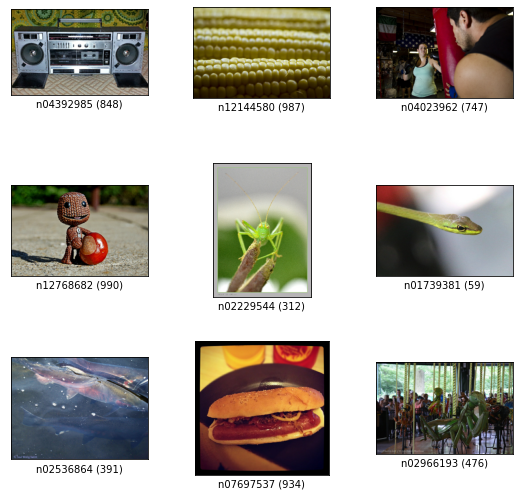

In [53]:
fig = tfds.show_examples(dataset_test_raw, dataset_info)

## Pre-processing the dataset

## Normalize dataset

In [54]:
# yields 37% prediction
def normalize_example(image, label):
    
    # one hot encoding to produce label as tensor
    label = tf.one_hot(tf.cast(label, tf.int32), len(classes))
    label = tf.cast(label, tf.float32)
    label = tf.reshape(label, [1, 1000])

    # see https://github.com/tensorflow/models/issues/517
    VGG_MEAN = [123.68, 116.78, 103.94]    # This is R-G-B for Imagenet
    means = tf.reshape(tf.constant(VGG_MEAN), [1, 1, 3])

    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    image = image - means 
    
    # Simply put, numpy.newaxis is used to increase the dimension of the existing array by one more dimension, 
    # when used once. Thus, 3D array becomes 4D array
    # see: https://i.stack.imgur.com/zkMBy.png
    image = image[np.newaxis, :]
            
    return (image, label)

In [55]:
# yields ~46% prediction
def normalize_example(image, label):
    
    encoded_lbl = tf.one_hot(tf.cast(label, tf.int32), 1000)
    encoded_lbl = tf.cast(encoded_lbl, tf.float32)
    encoded_lbl = tf.reshape(encoded_lbl, [1,1000])
    
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.vgg19.preprocess_input(image)
    image = tf.image.resize(image, [224,224])
    
    vMean = [0.485, 0.456, 0.406]
    vStd  = [0.229, 0.224, 0.225]
    image = image * vStd + vMean

    image = tf.reshape(image, [1,224,224,3])
    return image, encoded_lbl

In [56]:
# yields ~50% prediction
def normalize_example(image, label):
    
    encoded_lbl = tf.one_hot(tf.cast(label, tf.int32), 1000)
    encoded_lbl = tf.cast(encoded_lbl, tf.float32)
    encoded_lbl = tf.reshape(encoded_lbl, [1,1000])
    
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.vgg19.preprocess_input(image)
    image = tf.image.resize(image, [224,224])
    
     # see https://github.com/tensorflow/models/issues/517
    VGG_MEAN = [123.68, 116.78, 103.94]    # This is R-G-B for Imagenet
    means = tf.reshape(tf.constant(VGG_MEAN), [1, 1, 3])
    image = image - means 
    
    image = tf.reshape(image, [1,224,224,3])
    return image, encoded_lbl

In [57]:
# yields ~51% prediction
def normalize_example(image, label):
    
    encoded_lbl = tf.one_hot(tf.cast(label, tf.int32), 1000)
    encoded_lbl = tf.cast(encoded_lbl, tf.float32)
    encoded_lbl = tf.reshape(encoded_lbl, [1,1000])
    
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.vgg19.preprocess_input(image)
    image = tf.image.resize(image, [224,224])

    image = tf.reshape(image, [1,224,224,3])
    return image, encoded_lbl

In [58]:
datatest_normalized = dataset_test_raw.map(normalize_example)
print(datatest_normalized)

<MapDataset shapes: ((1, 224, 224, 3), (1, 1000)), types: (tf.float32, tf.float32)>


In [59]:
# aggregate the image,label in a convient way from DataSet
test_images = []
test_labels = []

for img, label in datatest_normalized.take(num_test_examples):
    test_images.append(img)
    test_labels.append(label)

In [60]:
mI = test_images[0]
print(type(mI))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [61]:
predicted_label = np.argmax(model.predict(mI), -1)[0]
predicted_label

209

In [62]:
actual_label = np.argmax(test_labels[0], -1)[0]
actual_label

209

In [63]:
match    = 0
no_match = 0
count    = 0
for i in range(num_classes):
    count += 1
    mI    = test_images[i]
    label = test_labels[i]
    
    predicted_label = np.argmax(model.predict(mI), -1)[0]
    actual_label    = np.argmax(label, -1)[0]
    
    if (predicted_label == actual_label):
        match += 1
    else:
        no_match += 1
        
    if (count % 30 == 0):    
        print(f"{i}: [MATCH : NO_MATCH]: {match / count * 100:0.1f}, {no_match / count * 100:0.1f}")      

print(f"[MATCH : NO_MATCH]: {match / count * 100:0.1f}, {no_match / count * 100:0.1f}")      

29: [MATCH : NO_MATCH]: 36.7, 63.3
59: [MATCH : NO_MATCH]: 41.7, 58.3
89: [MATCH : NO_MATCH]: 47.8, 52.2
119: [MATCH : NO_MATCH]: 45.8, 54.2
149: [MATCH : NO_MATCH]: 46.7, 53.3
179: [MATCH : NO_MATCH]: 47.8, 52.2
209: [MATCH : NO_MATCH]: 48.1, 51.9
239: [MATCH : NO_MATCH]: 49.2, 50.8
269: [MATCH : NO_MATCH]: 48.9, 51.1
299: [MATCH : NO_MATCH]: 49.0, 51.0
329: [MATCH : NO_MATCH]: 49.1, 50.9
359: [MATCH : NO_MATCH]: 48.9, 51.1
389: [MATCH : NO_MATCH]: 49.2, 50.8
419: [MATCH : NO_MATCH]: 50.2, 49.8
449: [MATCH : NO_MATCH]: 50.0, 50.0
479: [MATCH : NO_MATCH]: 50.2, 49.8
509: [MATCH : NO_MATCH]: 50.4, 49.6
539: [MATCH : NO_MATCH]: 50.2, 49.8
569: [MATCH : NO_MATCH]: 50.0, 50.0
599: [MATCH : NO_MATCH]: 50.5, 49.5
629: [MATCH : NO_MATCH]: 50.6, 49.4
659: [MATCH : NO_MATCH]: 50.2, 49.8
689: [MATCH : NO_MATCH]: 49.6, 50.4
719: [MATCH : NO_MATCH]: 50.3, 49.7
749: [MATCH : NO_MATCH]: 50.9, 49.1
779: [MATCH : NO_MATCH]: 50.6, 49.4
809: [MATCH : NO_MATCH]: 50.6, 49.4
839: [MATCH : NO_MATCH]: 50.4, 

https://keras.rstudio.com/reference/evaluate.html

In [64]:
batch_dataset_test = datatest_normalized.take(100)

In [65]:
test_loss, test_acc = model.evaluate(batch_dataset_test, verbose=2) 

100/100 - 4s - loss: 2.4410 - accuracy: 0.4900


In [66]:
model.save('./saved_model')

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


## Optimize the model using TensorRT

After training of the model and evaluating it, your goal is to optimize the model for inference on target machine using TensorRT (use TF-TRT in this project).

Try quantizing the model for different percisions using TensorRT quantization features, compare the different percision modes and recommand what you choose.

> Bonus: if you were working on Tesla T4 GPU, what percision mode had you chosen then?

In [ ]:
import subprocess as sp
import os
import time

num_of_iteration = 200

def get_gpu_memory():
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

def evaluate_model( ):
    mem_before = get_gpu_memory()[0]
    print("Available GPU Memory before loading: ", mem_before)

    model = tf.keras.models.load_model('./saved_model')
    mem_after = get_gpu_memory()[0]
    print("Available GPU Memory after loading: ", mem_after)
    
    start_time = time.time()
    success = 0
    for i in range(num_of_iteration):
        digit = np.argmax(model.predict(np.asanyarray([x_test[i]]),), axis=-1)
        if digit[0] == np.argmax(y_test[i]):
            success += 1
            
    print("Average FPS: ", num_of_iteration / (time.time() - start_time))
    print("GPU Memory Usage: " + str(mem_before - mem_after) + " MiB")
    print('\nTest accuracy:', float(success) / num_of_iteration)

# p = multiprocessing.Process(target=evaluate_model)
# p.start()
# p.join()
evaluate_model()

Available GPU Memory before loading:  339
Available GPU Memory after loading:  339


In [1]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import numpy as np
import random

def optimize_model_float(precision_str):
    converter = trt.TrtGraphConverterV2(input_saved_model_dir='./saved_model',
                                        conversion_params = tf.experimental.tensorrt.ConversionParams(
                                            precision_mode=precision_str,
                                        )
                                       )

    def my_input_fn():
        # Input for a single inference call, for a network that has two input tensors:
        yield (np.asanyarray([x_test[0]]),)
        
    print("Converting...")    
    converter.convert()
    print("Building...")    
    converter.build(my_input_fn)
    folder = './optimized_'+ precision_str
    print(f"Saving: {folder} ...")    
    converter.save(folder)
    
def optimize_model_int8(precision_str):
    converter = trt.TrtGraphConverterV2(input_saved_model_dir='./saved_model',
                                        conversion_params = tf.experimental.tensorrt.ConversionParams(
                                            precision_mode=precision_str,
                                        )
                                       )

    def my_input_fn():
        # Input for a single inference call, for a network that has two input tensors:
        yield (np.asanyarray([x_test[0]]),)
        
    def my_calibration_input_fn():
        for i in range(x_test.shape[0]):
            yield (np.asanyarray([x_test[i]]),) 

    print("Converting...")    
    converter.convert(calibration_input_fn=my_calibration_input_fn)
    print("Building...")    
    converter.build(my_input_fn)
    folder = './optimized_'+ precision_str
    print(f"Saving: {folder} ...")    
    converter.save(folder)

ImportError: cannot import name 'trt_convert' from 'tensorflow.python.compiler.tensorrt' (C:\Users\User6\anaconda3\lib\site-packages\tensorflow\python\compiler\tensorrt\__init__.py)

In [ ]:
optimize_model_float('FP32')

In [2]:
optimize_model_float('FP16')    

NameError: name 'optimize_model_float' is not defined

In [ ]:
optimize_model_int8('INT8')        

In [ ]:
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.framework import convert_to_constants

num_of_iteration = 200

def get_func_from_saved_model(saved_model_dir):
    saved_model_loaded = tf.saved_model.load(
      saved_model_dir, tags=[tag_constants.SERVING])
    graph_func = saved_model_loaded.signatures[
      signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    graph_func = convert_to_constants.convert_variables_to_constants_v2(graph_func)
    return graph_func

def evaluate_model( precision_str ):
    mem_before = get_gpu_memory()[0]
    print("Available GPU Memory before loading: ", mem_before)

    folder = './optimized_'+ precision_str
    model_func = get_func_from_saved_model(folder)
    mem_after = get_gpu_memory()[0]
    print("Available GPU Memory after loading: ", mem_after)

    success = 0
    start_time = time.time()
    for i in range(num_of_iteration):
        data = tf.convert_to_tensor(np.asanyarray([x_test[i]]))
        digit = np.argmax(model_func(data), axis=-1)[0]
        if digit == np.argmax(y_test[i]):
            success += 1

    print("Average FPS: ", num_of_iteration / float(time.time() - start_time))
    print("GPU Memory Usage: " + str(mem_before - mem_after) + " MiB")
    print('\nTest accuracy:', float(success) / num_of_iteration)

In [ ]:
#Evaluate optimized models
evaluate_model('FP32')

In [ ]:
#Evaluate optimized models
evaluate_model('FP16') 

In [ ]:
#Evaluate optimized models
evaluate_model('INT8')

#### Bonus: 
if you were working on Tesla T4 GPU, what percision mode had you chosen then?

https://www.microway.com/hpc-tech-tips/nvidia-turing-tesla-t4-hpc-performance-benchmarks/ 

https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/tesla-t4/t4-tensor-core-datasheet-951643.pdf

https://www.servethehome.com/nvidia-tesla-t4-ai-inferencing-gpu-review/3/

https://blog.inten.to/hardware-for-deep-learning-part-3-gpu-8906c1644664?gi=1481d7aac7cb

"There is a trend towards using FP16 (half precision) instead of FP32 (single precision) because lower precision calculations seem to be not critical for neural networks. This also makes the double precision (FP64) not useful, because additional precision gives nothing, 
while being slower"



"In addition to making possible to train and store larger models, switching to FP16 typically gives 2x speed improvement (2x more TFLOPS)"

"The situation is now changed with Turing architecture and the new series of RTX gaming cards (RTX 2070/2080/2080 Ti). Turing (Sept 2018)
chips support unrestricted FP16 calculations"

"Nvidia recently launched TESLA T4 inference accelerator with INT4 support, which is twice faster than INT8"

1. INT8 preformnace is higher thatn FP32
2. FP32 Memory Consumption is higher than INT8
3. Recommnded to use FP16, and not FP32 (i.e. use float and not double)

Conclusion (In General): For Training: use FP32
                         For Inference: use INT8               
                
CNN that were already trained alot  with FP32, is adviced to use FP16 and not INT8, since it might
affect accuracy after inference. (Although INT4/INT8 are much faster 130/260 TOPS than FP16/FP32 65/8 TOPS)

In [ ]:
!aws s3 cp ./train-objective-2.ipynb s3://uatt-e1-ronenle/